In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_train = pd.read_csv("dataset ideology/politicES_phase_2_train_public.csv", on_bad_lines='skip')

df_train.drop(['label','ideology_binary','gender','profession'], axis=1, inplace=True) 
df_train = df_train[:2000] #Probamos con 3000 por temas de computo

##  Clasificador

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset
import tqdm as notebook_tqdm

model_name = 'AIDA-UPM/BERTuit-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, from_tf=True)


/Users/juan/miniconda3/envs/master/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_train['ideology_multiclass'] = label_encoder.fit_transform(df_train['ideology_multiclass'])

In [4]:
# Función para tokenizar el dataset
def tokenize_function(example):
    return tokenizer(example['tweet'], max_length=512, truncation=True)

# Conversión del DataFrame de pandas a un Dataset de Hugging Face para pasarlo al modelo
huggingface_dataset = Dataset.from_pandas(df_train)
huggingface_dataset

Dataset({
    features: ['ideology_multiclass', 'tweet'],
    num_rows: 2000
})

In [5]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset = huggingface_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 22279.91 examples/s]


Dataset({
    features: ['ideology_multiclass', 'tweet', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [6]:
tokenized_dataset = tokenized_dataset.rename_column("ideology_multiclass", "labels") 
tokenized_dataset = tokenized_dataset.remove_columns("tweet")  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [7]:
from datasets import DatasetDict

# Dividimos los datos en entrenamiento y validación. Dejamos un 30% del dataset para validación y test
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
# test_valid_split = train_test_split['test'].train_test_split(test_size=0.66) # Dividimos entre conjunto de validación y test

# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
     
})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico


 33%|███▎      | 100/300 [03:04<05:34,  1.67s/it]

{'loss': 1.0613, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


/Users/juan/miniconda3/envs/master/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 33%|███▎      | 100/300 [03:17<05:34,  1.67s/it]

{'eval_loss': 0.9538622498512268, 'eval_accuracy': 0.58, 'eval_f1': 0.5628690439906532, 'eval_precision': 0.5568360786152815, 'eval_recall': 0.58, 'eval_runtime': 12.8961, 'eval_samples_per_second': 31.017, 'eval_steps_per_second': 1.939, 'epoch': 1.0}


 67%|██████▋   | 200/300 [06:11<02:51,  1.72s/it]

{'loss': 0.7883, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                 
 67%|██████▋   | 200/300 [06:24<02:51,  1.72s/it]

{'eval_loss': 0.8670852780342102, 'eval_accuracy': 0.625, 'eval_f1': 0.6213987879058127, 'eval_precision': 0.6278099143026005, 'eval_recall': 0.625, 'eval_runtime': 13.435, 'eval_samples_per_second': 29.773, 'eval_steps_per_second': 1.861, 'epoch': 2.0}


100%|██████████| 300/300 [09:25<00:00,  1.89s/it]

{'loss': 0.6421, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 300/300 [09:38<00:00,  1.89s/it]Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.8591510653495789, 'eval_accuracy': 0.6325, 'eval_f1': 0.6298403222629504, 'eval_precision': 0.6304954181870658, 'eval_recall': 0.6325, 'eval_runtime': 12.8011, 'eval_samples_per_second': 31.247, 'eval_steps_per_second': 1.953, 'epoch': 3.0}


100%|██████████| 300/300 [09:40<00:00,  1.94s/it]


{'train_runtime': 580.9695, 'train_samples_per_second': 8.262, 'train_steps_per_second': 0.516, 'train_loss': 0.8305491892496745, 'epoch': 3.0}


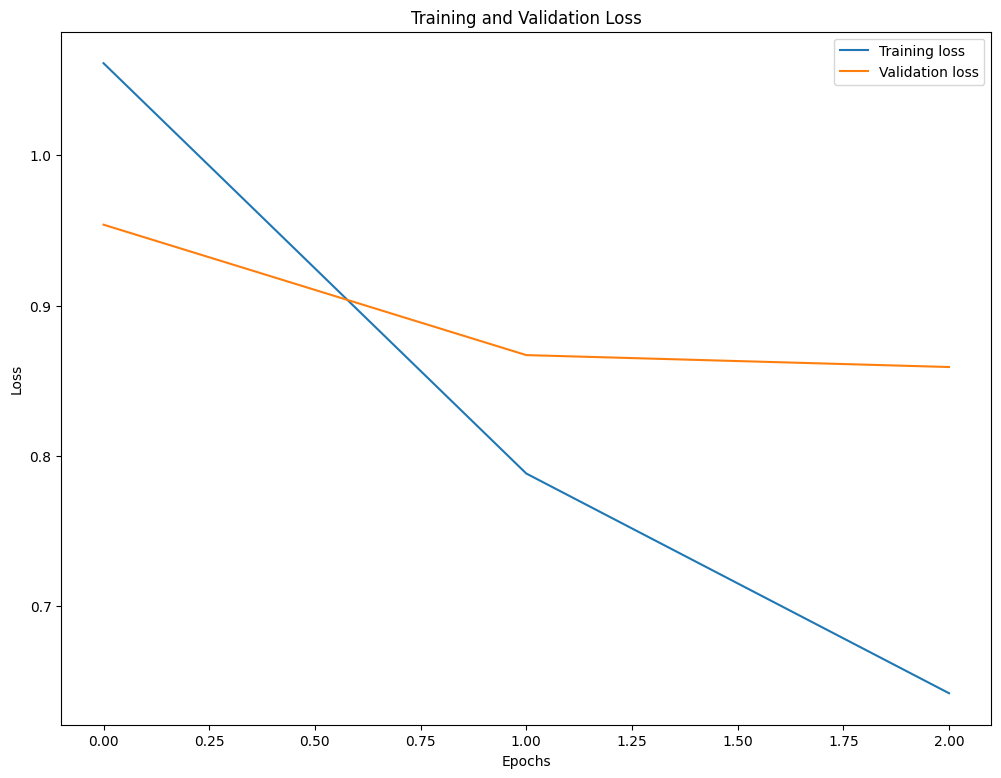

100%|██████████| 25/25 [00:11<00:00,  2.12it/s]

Resultados en el conjunto de validacion: {'eval_loss': 0.8591510653495789, 'eval_accuracy': 0.6325, 'eval_f1': 0.6298403222629504, 'eval_precision': 0.6304954181870658, 'eval_recall': 0.6325, 'eval_runtime': 12.3865, 'eval_samples_per_second': 32.293, 'eval_steps_per_second': 2.018, 'epoch': 3.0}


In [8]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy='epoch',
    logging_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(12, 9))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Imprimimos las métricas del conjunto de test
test_results = trainer.evaluate(eval_dataset=final_datasets['validation'])
print("Resultados en el conjunto de validacion:", test_results)


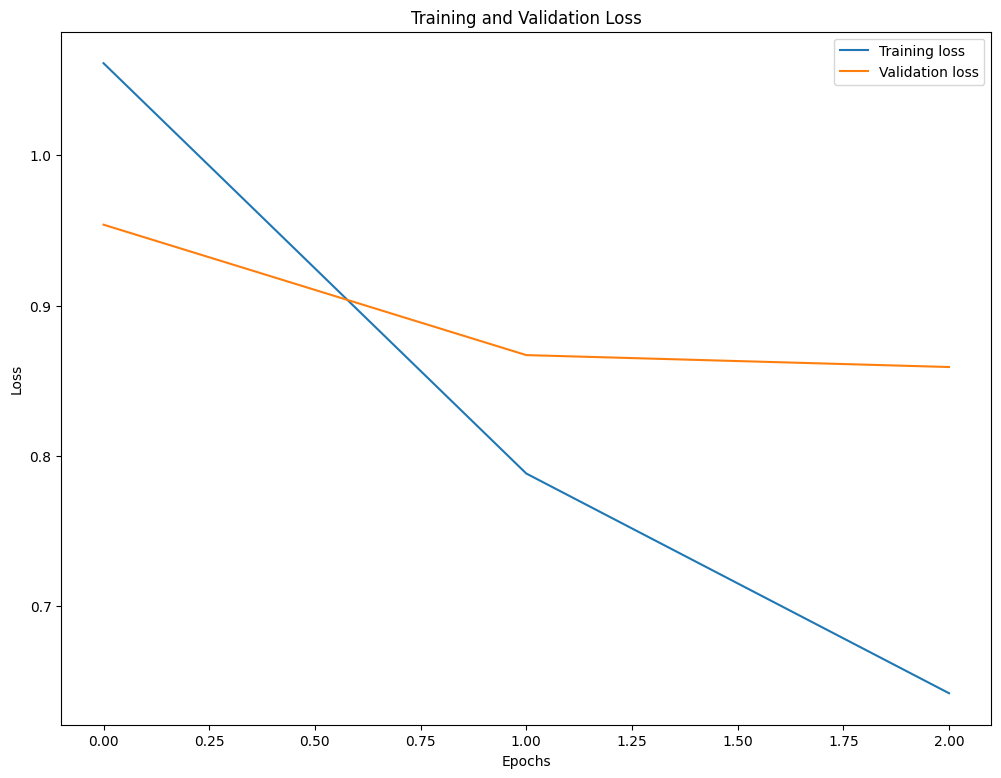

In [9]:
plt.figure(figsize=(12, 9))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()